In [1]:
from slmfunctions.dependencies import *
from slmfunctions.settings import *
from slmfunctions.simulation import *
from slmfunctions.imageprocessing import *
from slmfunctions.phaseretrieval import *

## More dependencies
import scipy.fft as spfft
from scipy.ndimage import gaussian_filter1d as sp_gaussian_filter1d
from scipy.ndimage import affine_transform as sp_affine_transform
from scipy.ndimage import gaussian_filter as sp_gaussian_filter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product

cupyon=True

try:
    import cupy as cp
    import cupyx.scipy.fft as cpfft
    import cupyx.scipy.ndimage
    from cupyx.scipy.ndimage import gaussian_filter1d as cp_gaussian_filter1d
    from cupyx.scipy.ndimage import gaussian_filter as cp_gaussian_filter
    from cupyx.scipy.ndimage import affine_transform as cp_affine_transform
except ImportError:
    cp = np
    cpfft = spfft
    cp_gaussian_filter1d = sp_gaussian_filter1d
    cp_gaussian_filter = sp_gaussian_filter
    cp_affine_transform = sp_affine_transform
    cupyon = False
    print("cupy not installed. Using numpy.")

# GLOBAL VARIABLES
numpixels = 1300
slmwidth = 1200
slmheight = 1920


cupy not installed. Using numpy.


In [21]:
######### Optimized tweezer generator

### Settings
gpuoptimization = True
#Phase Offsets available: Off_None, Off_Rand, Off_Calc 
optimizedinitialguess = True # If this is true, then phase offset is on 
phaseoffset = Off_Rand
phaseoffsetoptimization = True
# #Phase optimizers available: Phase_MinJumps, Phase_MinAmp
phaseoffsetfunction = Phase_MinJumps
harmonicremoval = True
# #Cost Functions available: Pen_DeltaSqrt, Pen_Sqrt, Pen_Exp
gwscostfunction = Pen_DeltaSqrt
# #Error Metrics available: Err_MaxMinDiff, Err_Uniformity, Err_PowerEff
errormetric = Err_MaxMinDiff

imgname = f"3by3_9spacing_mag3" # DEFINE NAME FIRST
tweezerarray = createtweezers_grid(cp.zeros((numpixels*3,numpixels*3)), 9, 3,3 )
# plt.imshow(zoomin(expand(tweezerarray,1)))

In [22]:
# Get the kvectors from the tweezer array
kvector_tweezers = makeinitialkvectors(tweezerarray)
harmonics = identifyharmonics(kvector_tweezers, 0)
harmonics_coordinates = frequenciestopixels_harmonicsonly(harmonics, tweezerarray)
# Calculate offsets
kvector_initoffsets = Off_Calc(kvector_tweezers.get_magnitude(0), kvector_tweezers.get_angle(0), tweezerarray)

In [23]:
# Get initial phase guess
initialphaseguess = create_phasemap(kvector_tweezers, kvector_initoffsets, wavetype=makesawtooth, opton=True, opttype=Phase_MinAmp, optiter=10)

In [24]:
# Derive necessary phase for tweezers
optimizedout  = derivephase(Pen_DeltaSqrt, tweezerarray, initialphaseguess, 60,1)

In [ ]:
optimizedout_randguess  = derivephase(Pen_DeltaSqrt, tweezerarray, cp.random.rand(numpixels, numpixels), 100,1)

In [29]:
kvector_initoffsets_none = Off_None(kvector_tweezers.get_magnitude(0), kvector_tweezers.get_angle(0), tweezerarray)
initialphaseguess_nooffsets = create_phasemap(kvector_tweezers, kvector_initoffsets_none, wavetype=makesawtooth, opton=True, opttype=Phase_MinAmp, optiter=10)
optimizedout_nooffsets  = derivephase(Pen_DeltaSqrt, tweezerarray, initialphaseguess_nooffsets, 1000,1)

In [25]:
# Convert to image files, and store!
import os
save_dir = r'Z:\nsong\NeutralAtoms\Ultracold-Research\GWS-Summer2024\storage'
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
phaseimg_path = os.path.join(save_dir, f"{imgname}_phase.bmp")
intimg_path = os.path.join(save_dir, f"{imgname}_virtualint.jpg")


saver = np.zeros((1200,1920))
saver[0:1200,int(1920/2-sizepix/2):int(1920/2+sizepix/2)] = optimizedout.get_slmphase().get()[50:1250,:] / np.max(optimizedout.get_slmphase().get()[50:1250,:])*255
phaseimg = (Image.fromarray(saver).convert('RGB'))
virtualintimg = (Image.fromarray(optimizedout.get_stdint().get() / np.max(optimizedout.get_stdint().get()) * 255).convert('RGB'))
phaseimg.save(phaseimg_path)
virtualintimg.save(intimg_path)

#####################################################3

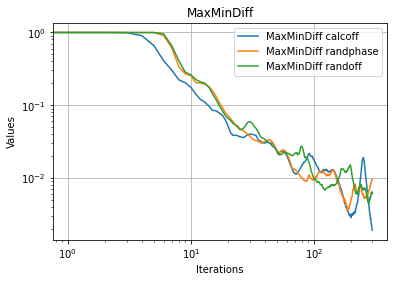

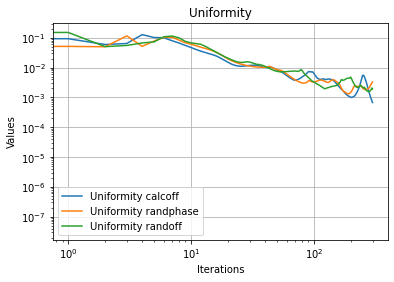

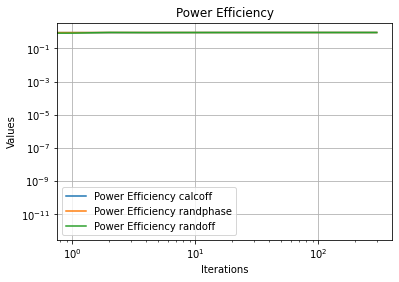

In [ ]:
errors = optimizedout.get_all_errors()
labels = optimizedout.get_all_labels()
errors_rand = optimizedout_randguess.get_all_errors()
labels_rand = optimizedout_randguess.get_all_labels()
errors_nooff = optimizedout_nooffsets.get_all_errors()
labels_nooff = optimizedout_nooffsets.get_all_labels()
for i, label in enumerate(labels):
    plt.figure()
    plt.loglog(errors[i].get(), label=str(cp.asnumpy(label))+" calcoff")
    plt.loglog(errors_rand[i].get(), label=str(cp.asnumpy(label))+" randphase")
    plt.loglog(errors_nooff[i].get(), label=str(cp.asnumpy(label))+" randoff")
    plt.title(label)
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Values')
    plt.grid(True)
    plt.show()


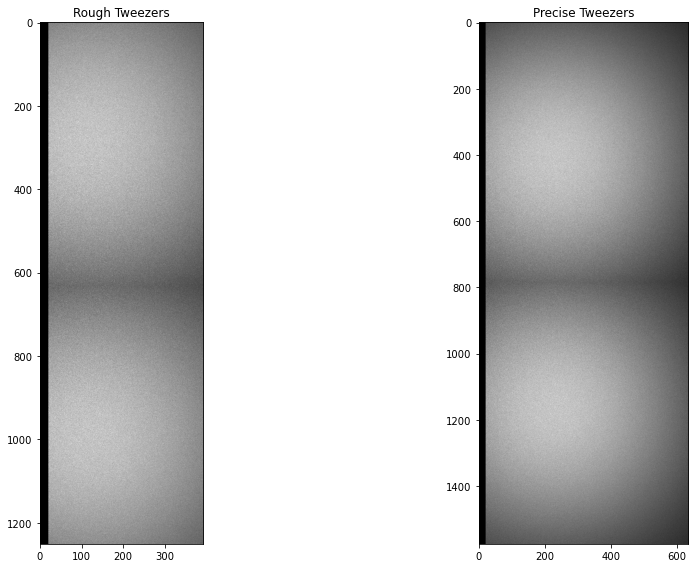

In [11]:
opt_tweezers_precise = simulatefourier(optimizedout.get_slmphase(), magnification=2)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
tweezers_rough = zoomin(removeleftside(removeedges((remove0thorder(optimizedout.get_stdint())))),20).get()
tweezers_precise =  zoomin(removeleftside(removeedges(remove0thorder(opt_tweezers_precise, 20))),5).get()
axs[0].imshow(tweezers_rough, cmap='gray')
axs[0].set_title('Rough Tweezers')
axs[1].imshow(tweezers_precise, cmap='gray')
axs[1].set_title('Precise Tweezers')
plt.tight_layout()
plt.show()

In [34]:
opt_tweezers_precise = remove0thorder(simulatefourier(zeropad(optimizedout.get_slmphase(), 1300), magnification=1))


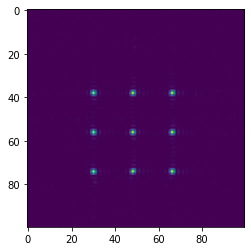

In [37]:
plt.imshow(opt_tweezers_precise.get()[1250:1350, 2050:2150])